In [40]:
import os
import sys
from glob import glob
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from collections import defaultdict
from io import StringIO
from utils import label_map_util
from utils import visualization_utils as vis_util
import random
from matplotlib import pyplot as plt
from PIL import Image
import time
%matplotlib inline

In [36]:
print(tf.__version__)

1.3.0


In [21]:
def load_graph(graph_file):
    """Loads a frozen inference graph"""
    graph = tf.Graph()
    with graph.as_default():
        od_graph_def = tf.GraphDef()
        with tf.gfile.GFile(graph_file, 'rb') as fid:
            serialized_graph = fid.read()
            od_graph_def.ParseFromString(serialized_graph)
            tf.import_graph_def(od_graph_def, name='')
    return graph


def load_image_into_numpy_array(image):
    (im_width, im_height) = image.size
    return np.array(image.getdata()).reshape((im_height, im_width, 3)).astype(np.uint8)

In [22]:
## Test model
# PATH_TO_GRAPH = r'models/rcnn_resnet101/frozen_inference_graph.pb'
# PATH_TO_GRAPH = r'models/rcnn/frozen_inference_graph.pb'
PATH_TO_GRAPH = r'./model/ssd_sim/frozen_inference_graph.pb' ## load SSD trained on udacity's parking lot images
PATH_TO_LABELS = r'./model/label_map.pbtxt'
NUM_CLASSES = 13

In [23]:
detection_graph = load_graph(PATH_TO_GRAPH)

In [24]:
label_map = label_map_util.load_labelmap(PATH_TO_LABELS)
categories = label_map_util.convert_label_map_to_categories(label_map, max_num_classes=NUM_CLASSES, use_display_name=True)
category_index = label_map_util.create_category_index(categories)
print(category_index)

{1: {'id': 1, 'name': 'Green'}, 2: {'id': 2, 'name': 'Red'}, 3: {'id': 3, 'name': 'Yellow'}, 4: {'id': 4, 'name': 'off'}}


In [47]:
PATH_TO_TEST_IMAGES_DIR = './data/sim_training_data/sim_data_capture/'

print(os.path.join(PATH_TO_TEST_IMAGES_DIR, 'left002*.jpg'))
TEST_IMAGE_PATHS = glob(os.path.join(PATH_TO_TEST_IMAGES_DIR, 'left002*.jpg'))
print("Length of test images:", len(TEST_IMAGE_PATHS))

# Size, in inches, of the output images.
IMAGE_SIZE = (12, 8)

./data/sim_training_data/sim_data_capture/left002*.jpg
Length of test images: 10


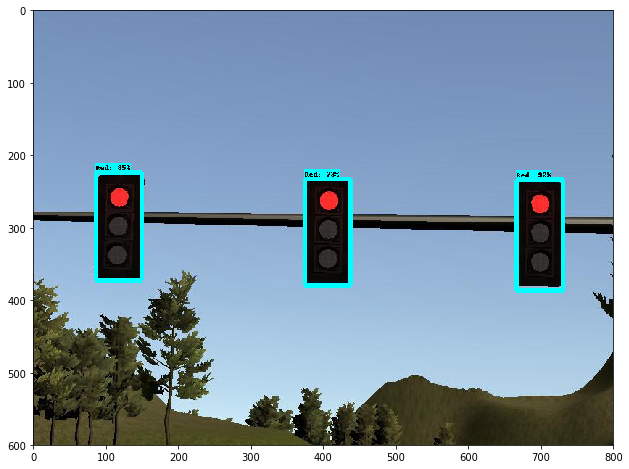

Red 0.928804
Distance (metres) 0.0
Time in milliseconds 815.5572414398193 

Red 0.856429
Distance (metres) 0.0
Time in milliseconds 815.5572414398193 

Red 0.735128
Distance (metres) 0.0
Time in milliseconds 815.5572414398193 



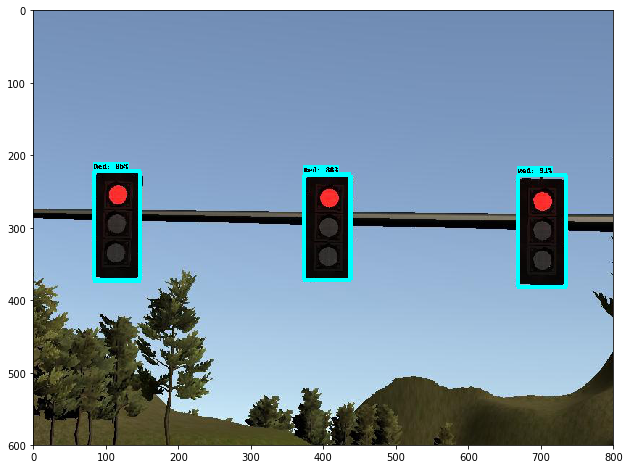

Red 0.917673
Distance (metres) 0.0
Time in milliseconds 78.26495170593262 

Red 0.868717
Distance (metres) 0.0
Time in milliseconds 78.26495170593262 

Red 0.855981
Distance (metres) 0.0
Time in milliseconds 78.26495170593262 



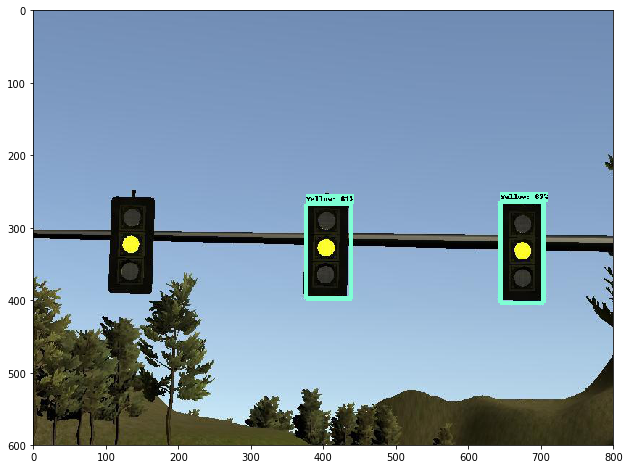

Yellow 0.678929
Distance (metres) 0.0
Time in milliseconds 83.01758766174316 

Yellow 0.613017
Distance (metres) 0.0
Time in milliseconds 83.01758766174316 



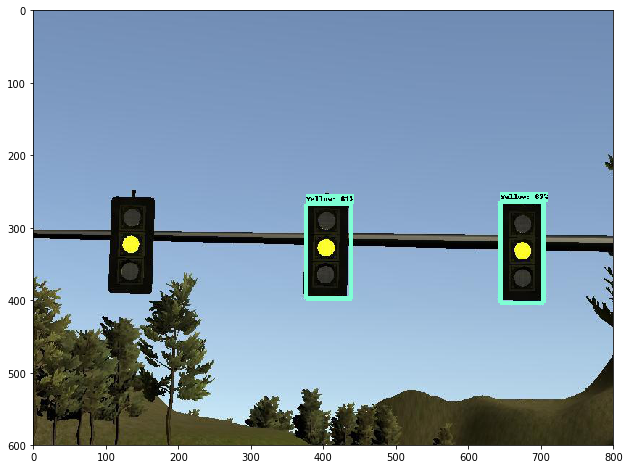

Yellow 0.678929
Distance (metres) 0.0
Time in milliseconds 79.17046546936035 

Yellow 0.613017
Distance (metres) 0.0
Time in milliseconds 79.17046546936035 



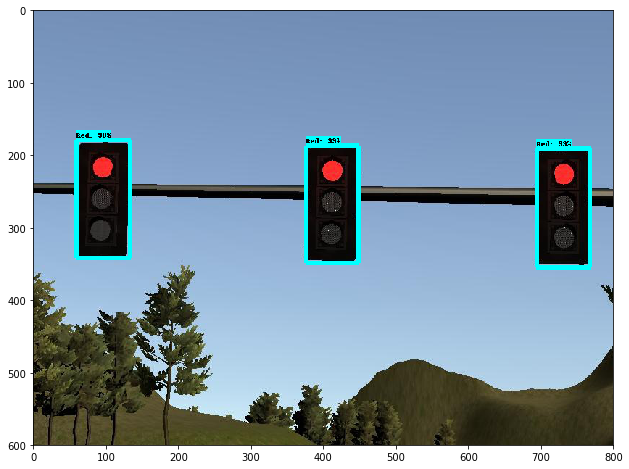

Red 0.999165
Distance (metres) 0.0
Time in milliseconds 78.72843742370605 

Red 0.99333
Distance (metres) 0.0
Time in milliseconds 78.72843742370605 

Red 0.988537
Distance (metres) 0.0
Time in milliseconds 78.72843742370605 



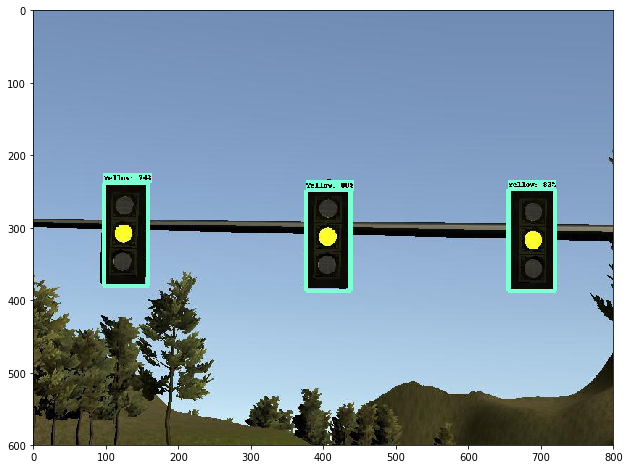

Yellow 0.883498
Distance (metres) 0.0
Time in milliseconds 80.7180404663086 

Yellow 0.821541
Distance (metres) 0.0
Time in milliseconds 80.7180404663086 

Yellow 0.749077
Distance (metres) 0.0
Time in milliseconds 80.7180404663086 



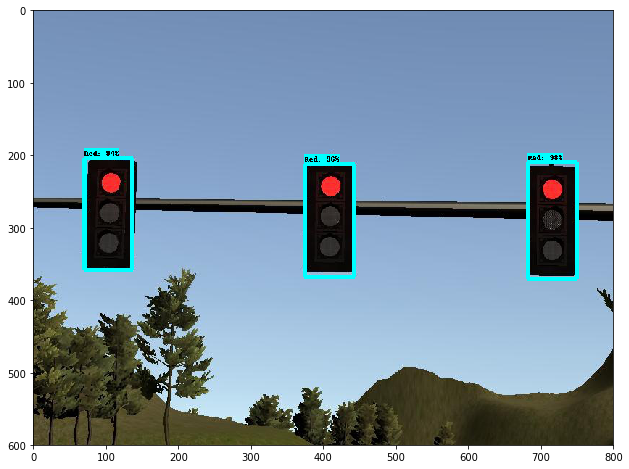

Red 0.988424
Distance (metres) 0.0
Time in milliseconds 80.92212677001953 

Red 0.968002
Distance (metres) 0.0
Time in milliseconds 80.92212677001953 

Red 0.942951
Distance (metres) 0.0
Time in milliseconds 80.92212677001953 



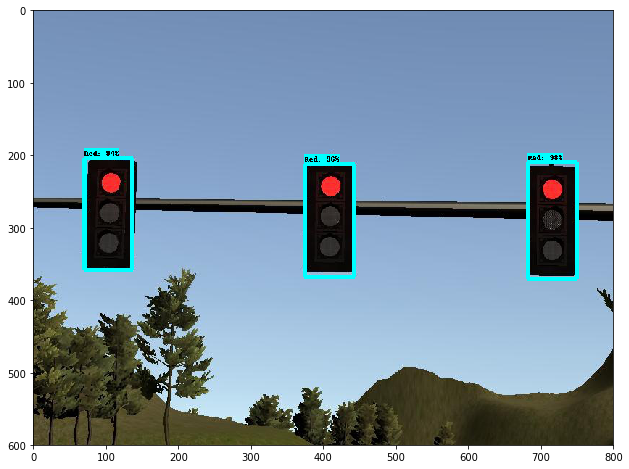

Red 0.988424
Distance (metres) 0.0
Time in milliseconds 80.1858901977539 

Red 0.968002
Distance (metres) 0.0
Time in milliseconds 80.1858901977539 

Red 0.942951
Distance (metres) 0.0
Time in milliseconds 80.1858901977539 



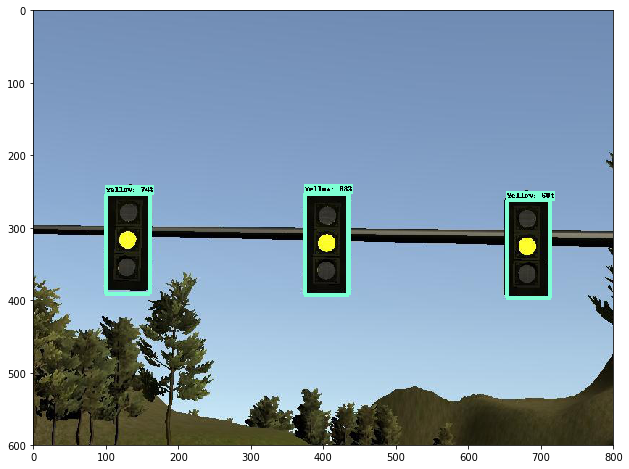

Yellow 0.740255
Distance (metres) 0.0
Time in milliseconds 82.80754089355469 

Yellow 0.68017
Distance (metres) 0.0
Time in milliseconds 82.80754089355469 

Yellow 0.601636
Distance (metres) 0.0
Time in milliseconds 82.80754089355469 



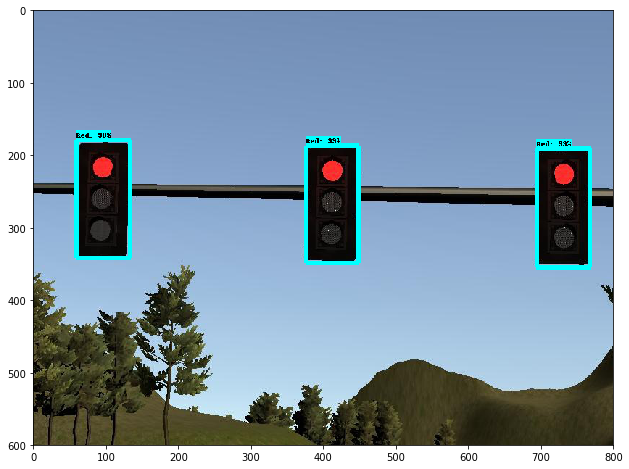

Red 0.999165
Distance (metres) 0.0
Time in milliseconds 81.06684684753418 

Red 0.99333
Distance (metres) 0.0
Time in milliseconds 81.06684684753418 

Red 0.988537
Distance (metres) 0.0
Time in milliseconds 81.06684684753418 



In [48]:
with detection_graph.as_default():
    with tf.Session(graph=detection_graph) as sess:
        # Definite input and output Tensors for detection_graph
        image_tensor = detection_graph.get_tensor_by_name('image_tensor:0')
        
        # Each box represents a part of the image where a particular object was detected.
        detection_boxes = detection_graph.get_tensor_by_name('detection_boxes:0')
        
        # Each score represent how level of confidence for each of the objects.
        # Score is shown on the result image, together with the class label.
        detection_scores = detection_graph.get_tensor_by_name('detection_scores:0')
        detection_classes = detection_graph.get_tensor_by_name('detection_classes:0')
        num_detections = detection_graph.get_tensor_by_name('num_detections:0')
        for image_path in TEST_IMAGE_PATHS:
            image = Image.open(image_path)
            # the array based representation of the image will be used later in order to prepare the
            # result image with boxes and labels on it.
            image_np = load_image_into_numpy_array(image)
            # Expand dimensions since the model expects images to have shape: [1, None, None, 3]
            image_np_expanded = np.expand_dims(image_np, axis=0)

            time0 = time.time()

            # Actual detection.
            (boxes, scores, classes, num) = sess.run(
              [detection_boxes, detection_scores, detection_classes, num_detections],
              feed_dict={image_tensor: image_np_expanded})

            time1 = time.time()

            boxes = np.squeeze(boxes)
            scores = np.squeeze(scores)
            classes = np.squeeze(classes).astype(np.int32)
            
            # Visualization of the results of a detection.
            vis_util.visualize_boxes_and_labels_on_image_array(
                image_np, boxes, classes, scores,
                category_index,
                use_normalized_coordinates=True,
                line_thickness=6)
            
            plt.figure(figsize=IMAGE_SIZE)
            plt.imshow(image_np)
            plt.show()

            min_score_thresh = .50
            for i in range(boxes.shape[0]):
                if scores is None or scores[i] > min_score_thresh:

                    class_name = category_index[classes[i]]['name']
                    print('{}'.format(class_name), scores[i])
                    
                    fx =  0.97428
                    fy =  1.73205
                    perceived_width_x = (boxes[i][3] - boxes[i][1]) * 800
                    perceived_width_y = (boxes[i][2] - boxes[i][0]) * 600

                    # ymin, xmin, ymax, xmax = box
                    # depth_prime = (width_real * focal) / perceived_width
                    perceived_depth_x = ((.1 * fx) / perceived_width_x)
                    perceived_depth_y = ((.3 * fy) / perceived_width_y )

                    estimated_distance = round((perceived_depth_x + perceived_depth_y) / 2)
                    print("Distance (metres)", estimated_distance)
                    print("Time in milliseconds", (time1 - time0) * 1000, "\n")

In [56]:
## Test model
# PATH_TO_GRAPH = r'models/rcnn_resnet101/frozen_inference_graph.pb'
# PATH_TO_GRAPH = r'models/rcnn/frozen_inference_graph.pb'
PATH_TO_GRAPH2 = r'./model/ssd_udacity/frozen_inference_graph.pb' ## load SSD trained on udacity's parking lot images
PATH_TO_LABELS = r'./model/label_map.pbtxt'
NUM_CLASSES = 13

In [60]:
detection_graph = load_graph(PATH_TO_GRAPH2)

In [61]:
label_map = label_map_util.load_labelmap(PATH_TO_LABELS)
categories = label_map_util.convert_label_map_to_categories(label_map, max_num_classes=NUM_CLASSES, use_display_name=True)
category_index = label_map_util.create_category_index(categories)
print(category_index)

{1: {'id': 1, 'name': 'Green'}, 2: {'id': 2, 'name': 'Red'}, 3: {'id': 3, 'name': 'Yellow'}, 4: {'id': 4, 'name': 'off'}}


In [ ]:
PATH_TO_TEST_IMAGES_DIR = './data/real_training_data/yellow/'

print(os.path.join(PATH_TO_TEST_IMAGES_DIR, 'left008**.jpg'))
TEST_IMAGE_PATHS = glob(os.path.join(PATH_TO_TEST_IMAGES_DIR, 'left008*.jpg'))
print("Length of test images:", len(TEST_IMAGE_PATHS))

# Size, in inches, of the output images.
IMAGE_SIZE = (12, 8)

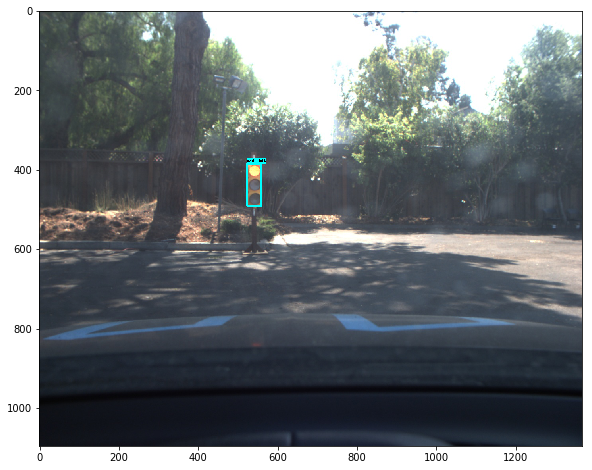

Red 0.990739
Distance (metres) 0.0
Time in milliseconds 898.3285427093506 



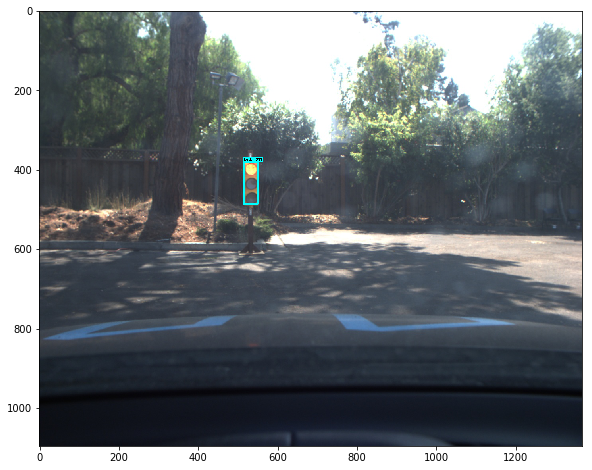

Red 0.998598
Distance (metres) 0.0
Time in milliseconds 89.47157859802246 



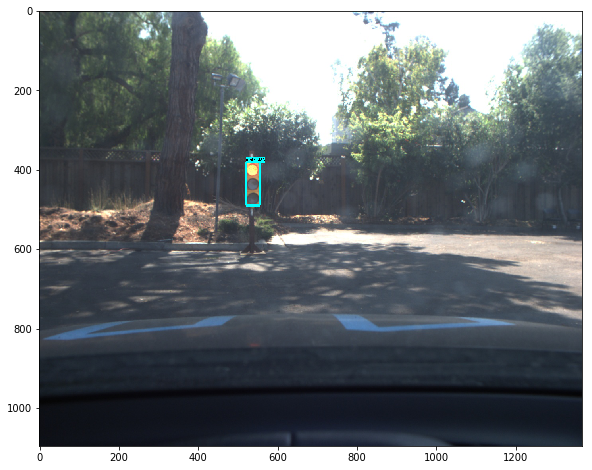

Red 0.996307
Distance (metres) 0.0
Time in milliseconds 90.51346778869629 



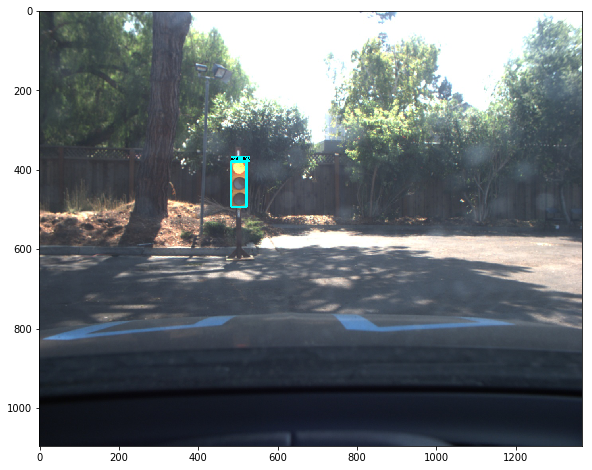

Red 0.998151
Distance (metres) 0.0
Time in milliseconds 88.0887508392334 



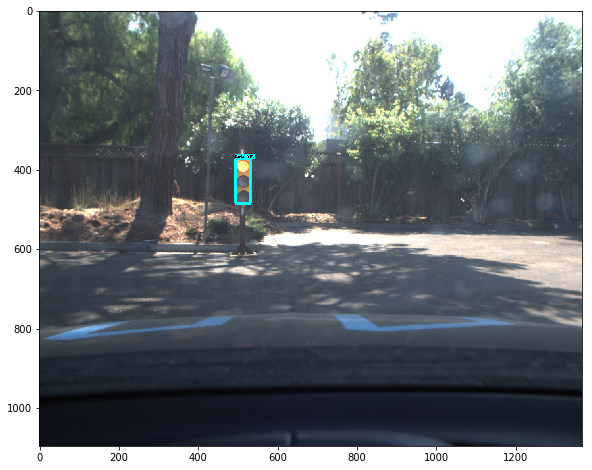

Red 0.999347
Distance (metres) 0.0
Time in milliseconds 89.9050235748291 



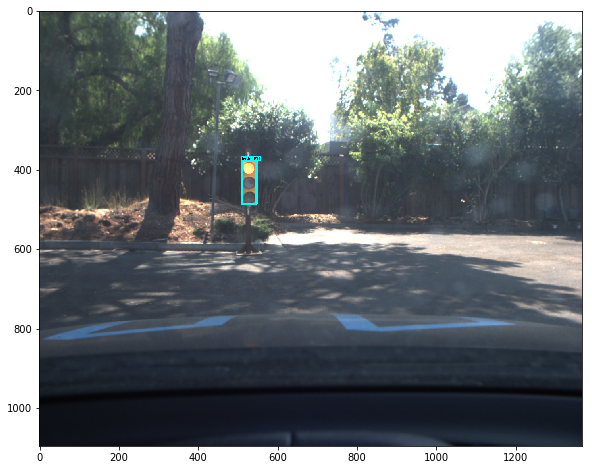

Red 0.998853
Distance (metres) 0.0
Time in milliseconds 89.96081352233887 



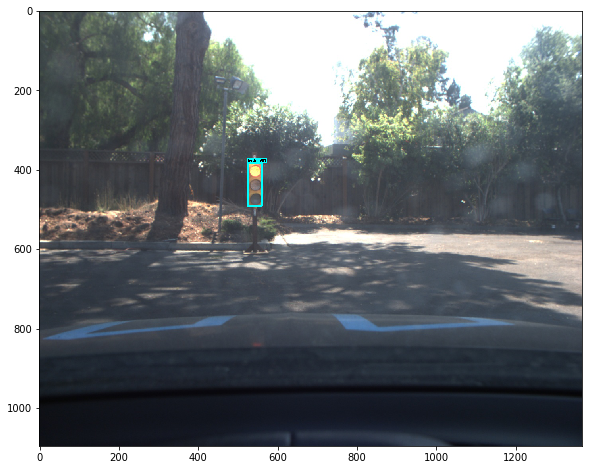

Red 0.997149
Distance (metres) 0.0
Time in milliseconds 91.32528305053711 



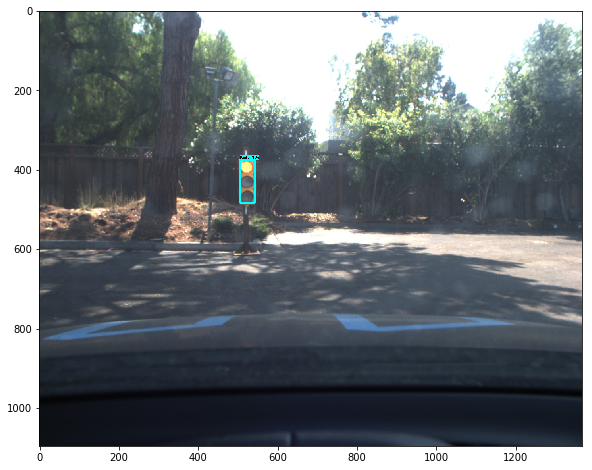

Red 0.998922
Distance (metres) 0.0
Time in milliseconds 89.41960334777832 



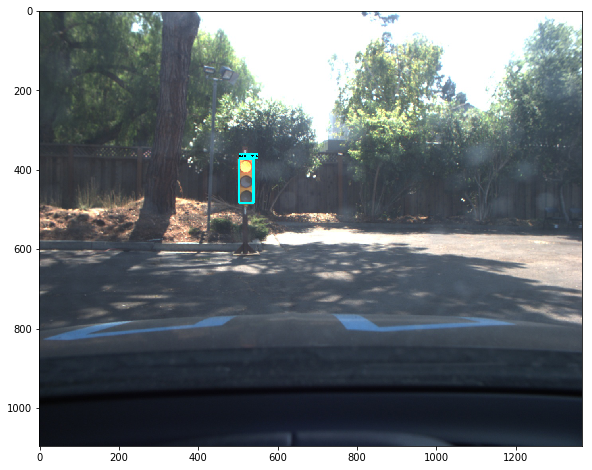

Red 0.998588
Distance (metres) 0.0
Time in milliseconds 94.3143367767334 



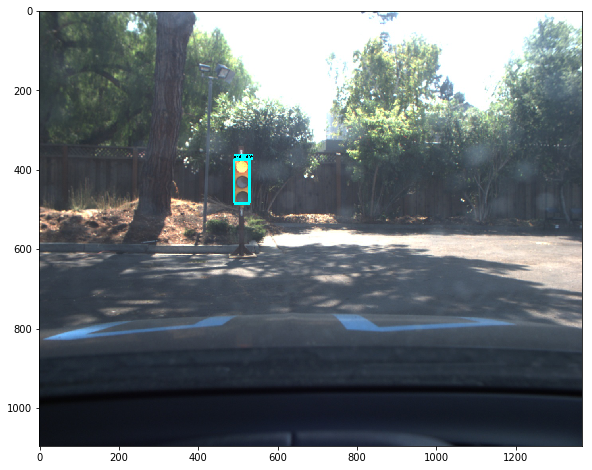

Red 0.999397
Distance (metres) 0.0
Time in milliseconds 90.15989303588867 



In [63]:
with detection_graph.as_default():
    with tf.Session(graph=detection_graph) as sess:
        # Definite input and output Tensors for detection_graph
        image_tensor = detection_graph.get_tensor_by_name('image_tensor:0')
        
        # Each box represents a part of the image where a particular object was detected.
        detection_boxes = detection_graph.get_tensor_by_name('detection_boxes:0')
        
        # Each score represent how level of confidence for each of the objects.
        # Score is shown on the result image, together with the class label.
        detection_scores = detection_graph.get_tensor_by_name('detection_scores:0')
        detection_classes = detection_graph.get_tensor_by_name('detection_classes:0')
        num_detections = detection_graph.get_tensor_by_name('num_detections:0')
        for image_path in TEST_IMAGE_PATHS:
            image = Image.open(image_path)
            # the array based representation of the image will be used later in order to prepare the
            # result image with boxes and labels on it.
            image_np = load_image_into_numpy_array(image)
            # Expand dimensions since the model expects images to have shape: [1, None, None, 3]
            image_np_expanded = np.expand_dims(image_np, axis=0)

            time0 = time.time()

            # Actual detection.
            (boxes, scores, classes, num) = sess.run(
              [detection_boxes, detection_scores, detection_classes, num_detections],
              feed_dict={image_tensor: image_np_expanded})

            time1 = time.time()

            boxes = np.squeeze(boxes)
            scores = np.squeeze(scores)
            classes = np.squeeze(classes).astype(np.int32)
            
            # Visualization of the results of a detection.
            vis_util.visualize_boxes_and_labels_on_image_array(
                image_np, boxes, classes, scores,
                category_index,
                use_normalized_coordinates=True,
                line_thickness=6)
            
            plt.figure(figsize=IMAGE_SIZE)
            plt.imshow(image_np)
            plt.show()

            min_score_thresh = .50
            for i in range(boxes.shape[0]):
                if scores is None or scores[i] > min_score_thresh:

                    class_name = category_index[classes[i]]['name']
                    print('{}'.format(class_name), scores[i])
                    
                    fx =  0.97428
                    fy =  1.73205
                    perceived_width_x = (boxes[i][3] - boxes[i][1]) * 800
                    perceived_width_y = (boxes[i][2] - boxes[i][0]) * 600

                    # ymin, xmin, ymax, xmax = box
                    # depth_prime = (width_real * focal) / perceived_width
                    perceived_depth_x = ((.1 * fx) / perceived_width_x)
                    perceived_depth_y = ((.3 * fy) / perceived_width_y )

                    estimated_distance = round((perceived_depth_x + perceived_depth_y) / 2)
                    print("Distance (metres)", estimated_distance)
                    print("Time in milliseconds", (time1 - time0) * 1000, "\n")